In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
import networkx as nx

Data Importation into jupyter

In [39]:
market_basket= pd.read_csv('C:/Users/bhindan/Documents/Data Chic/Market Basket Analysis - Groceries_dataset.csv')

market_basket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB




## Data Cleaning

## Handling Missing Values

I started the analysis by examining the dataset for missing values. After identifying the missing values, through following steps:

- [ ] Checked the distribution of missing values across columns.
- [ ] Corrected the dateformat.
- [ ] Checked for missing values to ensure data accuracy 





In [47]:
market_basket['Date'] = pd.to_datetime(market_basket['Date'], dayfirst=True)
print(market_basket.columns)

Index(['Member_number', 'Date', 'itemDescription', 'Month', 'Cluster'], dtype='object')


In [41]:
# Checking for missing values
missing_values = market_basket.isnull().sum()

print(market_basket.info())

# Display the first few rows of the DataFrame
print(market_basket.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Member_number    38765 non-null  int64         
 1   Date             38765 non-null  datetime64[ns]
 2   itemDescription  38765 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 908.7+ KB
None
   Member_number       Date   itemDescription
0           1808 2015-07-21    tropical fruit
1           2552 2015-01-05        whole milk
2           2300 2015-09-19         pip fruit
3           1187 2015-12-12  other vegetables
4           3037 2015-02-01        whole milk


Data Transformation: I introduced a binary item matrix as it is a transformation step. Converting transactional data into a format that's suitable for market basket analysis and association rule mining.

Exploratory Data Analysis (EDA)


Generated summary statistics to get an overview of the dataset.

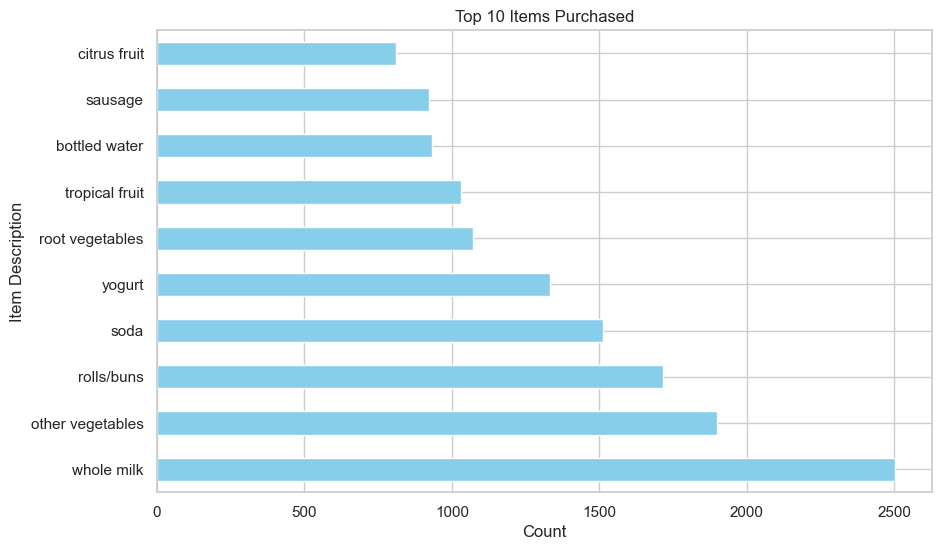

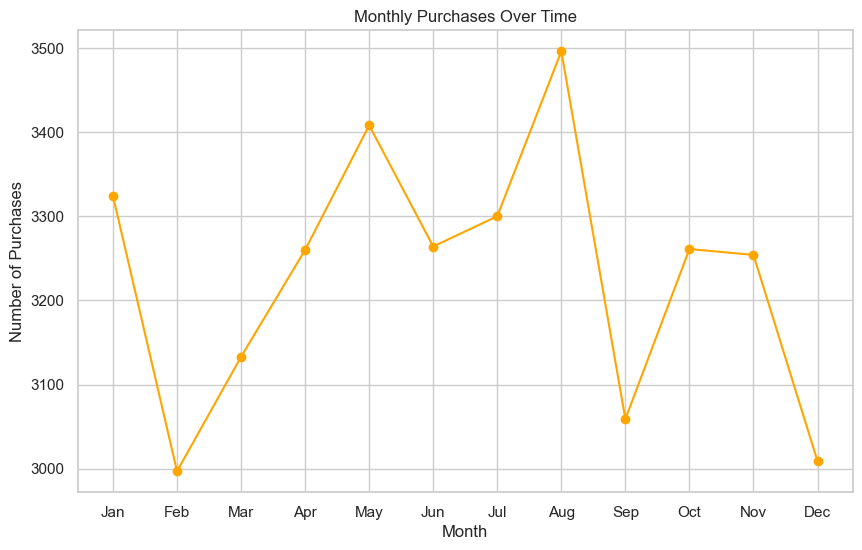

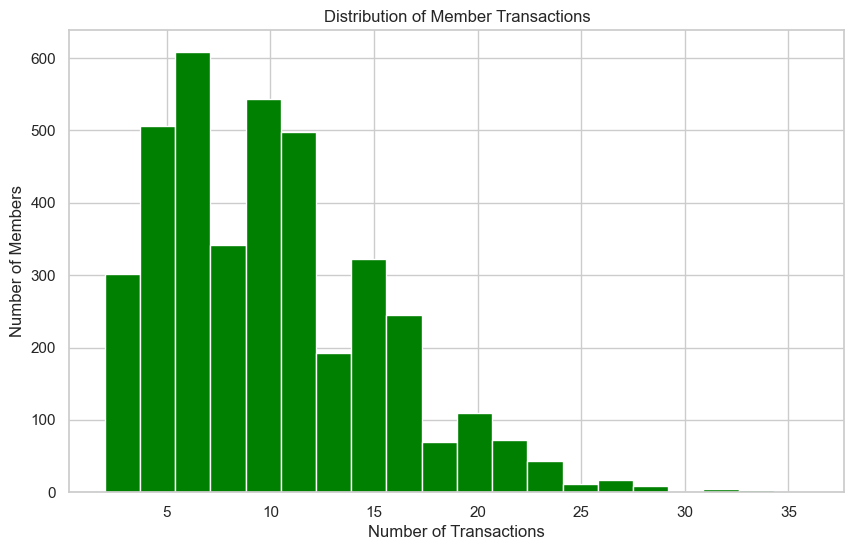

In [42]:


# Distribution of items purchased
item_counts = market_basket['itemDescription'].value_counts()

# top 10 items
top_n = 10
plt.figure(figsize=(10, 6))
item_counts.head(top_n).plot(kind='barh', color='skyblue')
plt.title(f'Top {top_n} Items Purchased')
plt.xlabel('Count')
plt.ylabel('Item Description')
plt.show()

# Frequency of purchases over time
market_basket['Month'] = market_basket['Date'].dt.month
monthly_purchases = market_basket.groupby('Month')['itemDescription'].count()

#monthly purchases plots
plt.figure(figsize=(10, 6))
monthly_purchases.plot(kind='line', marker='o', color='orange')
plt.title('Monthly Purchases Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Finding common patterns in member transactions
member_transactions = market_basket.groupby('Member_number')['itemDescription'].count()

# distribution of member transactions
plt.figure(figsize=(10, 6))
member_transactions.plot(kind='hist', bins=20, color='green')
plt.title('Distribution of Member Transactions')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Members')
plt.show()


# Customer Segmentation

## K-Means Segmentation

K-means clustering was applied to segment customers based on their purchasing behavior. This segmentation provides insights into different customer groups and can be utilized for targeted marketing strategies.




In [43]:
# Creating a binary matrix for items
item_matrix = pd.get_dummies(market_basket['itemDescription'])

# K-means clustering model
n_clusters = 3 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pipeline = make_pipeline(StandardScaler(), kmeans)
clusters = pipeline.fit_predict(item_matrix)

#Adding cluster labels to the original DataFrame
market_basket['Cluster'] = clusters

# Displaying the distribution of items in each cluster
cluster_item_distribution = market_basket.groupby(['Cluster', 'itemDescription']).size().unstack(fill_value=0)
cluster_item_distribution_percentage = cluster_item_distribution.div(cluster_item_distribution.sum(axis=1), axis=0) * 100

print(cluster_item_distribution_percentage)



c:\Users\bhindan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


itemDescription  Instant food products  UHT-milk  abrasive cleaner  \
Cluster                                                              
0                             0.160716  0.865186          0.058929   
1                             0.000000  0.000000          0.000000   
2                             0.000000  0.000000          0.000000   

itemDescription  artif. sweetener  baby cosmetics      bags  baking powder  \
Cluster                                                                      
0                        0.077679        0.008036  0.010714       0.326789   
1                        0.000000        0.000000  0.000000       0.000000   
2                        0.000000        0.000000  0.000000       0.000000   

itemDescription  bathroom cleaner      beef   berries  ...    turkey  \
Cluster                                                ...             
0                        0.045536  1.382155  0.875901  ...  0.214288   
1                        0.000000  0.00000

In [44]:
# Display the distribution of items in each cluster
cluster_item_distribution_percentage = market_basket.groupby(['Cluster', 'itemDescription']).size().unstack(fill_value=0)
cluster_item_distribution_percentage = cluster_item_distribution_percentage.div(cluster_item_distribution_percentage.sum(axis=1), axis=0) * 100

# Print the interpretation
for cluster in cluster_item_distribution_percentage.index:
    print(f"\nCluster {cluster}:")
    
    # Top 5 items in each cluster
    top_items = cluster_item_distribution_percentage.loc[cluster].sort_values(ascending=False).head(5)
    print(f"- Top 5 Items: {', '.join(top_items.index)}")
    
    # Key characteristics or observations
    if cluster == 0:
        print("- Diverse purchasing pattern with a mix of items.")
        print("- Higher percentage of items like beef, berries, and whipped/sour cream.")
    elif cluster == 1:
        print("- Dominant purchasing pattern with specific items.")
        print("- Represents a group with focused preferences.")
    elif cluster == 2:
        print("- Purchasing pattern dominated by a specific item (yogurt).")
    
    # adding a separator for clarity
    print("\n" + "-"*40)

# Printing insights
print("\nActionable Insights:")
print("\nCluster 0:")
print("- Targeted promotions and discounts on popular items.")
print("- Identify cross-selling opportunities for items with higher percentages.")

print("\nCluster 1:")
print("- Tailor marketing strategies to dominant items.")
print("- Explore product bundles featuring key items.")

print("\nCluster 2:")
print("- Develop yogurt-focused marketing campaigns.")
print("- Explore complementary items to promote alongside yogurt.")



Cluster 0:
- Top 5 Items: whole milk, other vegetables, rolls/buns, soda, root vegetables
- Diverse purchasing pattern with a mix of items.
- Higher percentage of items like beef, berries, and whipped/sour cream.

----------------------------------------

Cluster 1:
- Top 5 Items: condensed milk, Instant food products, processed cheese, photo/film, pickled vegetables
- Dominant purchasing pattern with specific items.
- Represents a group with focused preferences.

----------------------------------------

Cluster 2:
- Top 5 Items: yogurt, Instant food products, processed cheese, photo/film, pickled vegetables
- Purchasing pattern dominated by a specific item (yogurt).

----------------------------------------

Actionable Insights:

Cluster 0:
- Targeted promotions and discounts on popular items.
- Identify cross-selling opportunities for items with higher percentages.

Cluster 1:
- Tailor marketing strategies to dominant items.
- Explore product bundles featuring key items.

Cluster 2

Visualization

Created visualizations to explore the distribution of key variables.

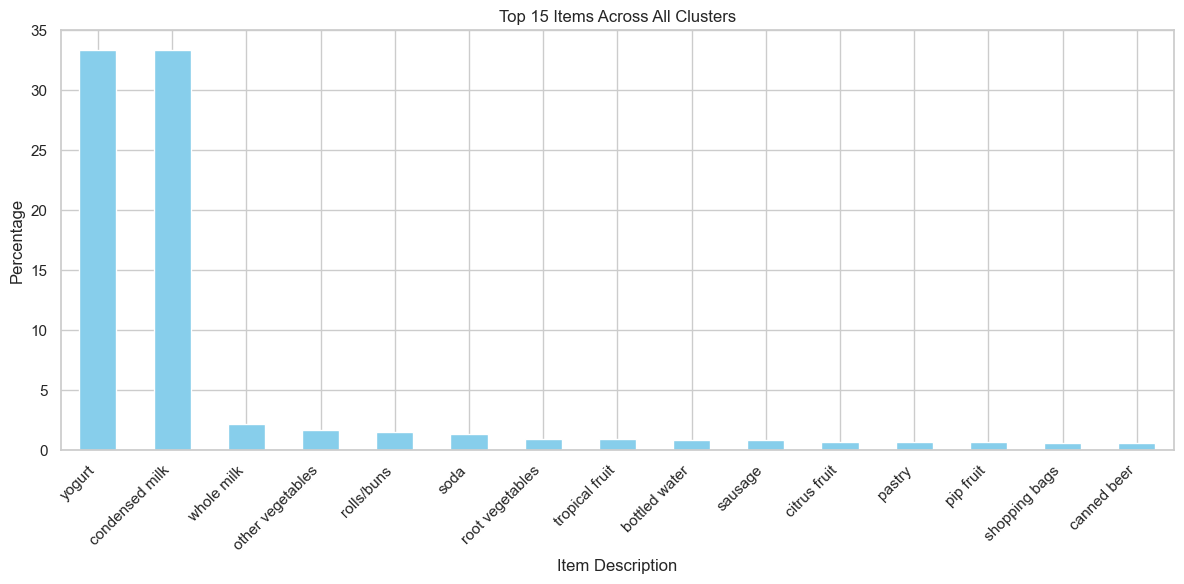

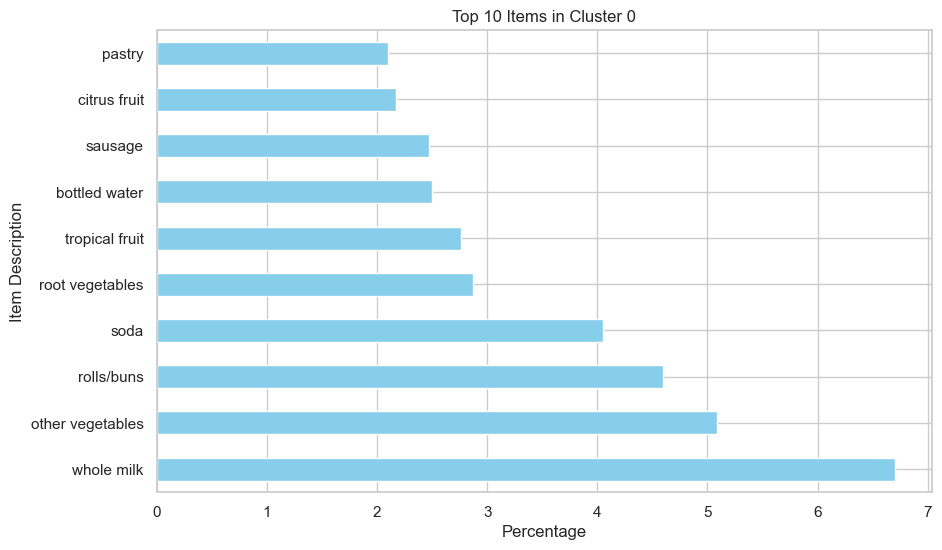

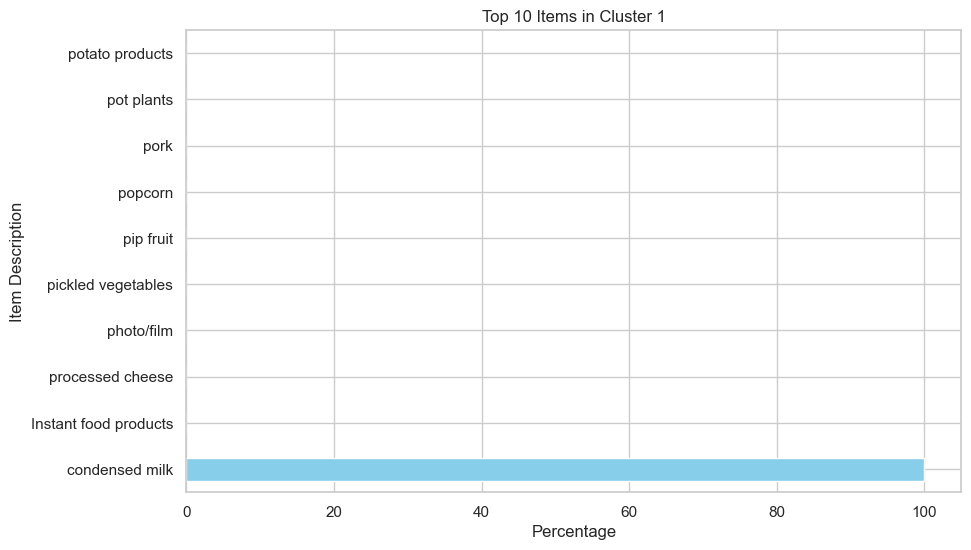

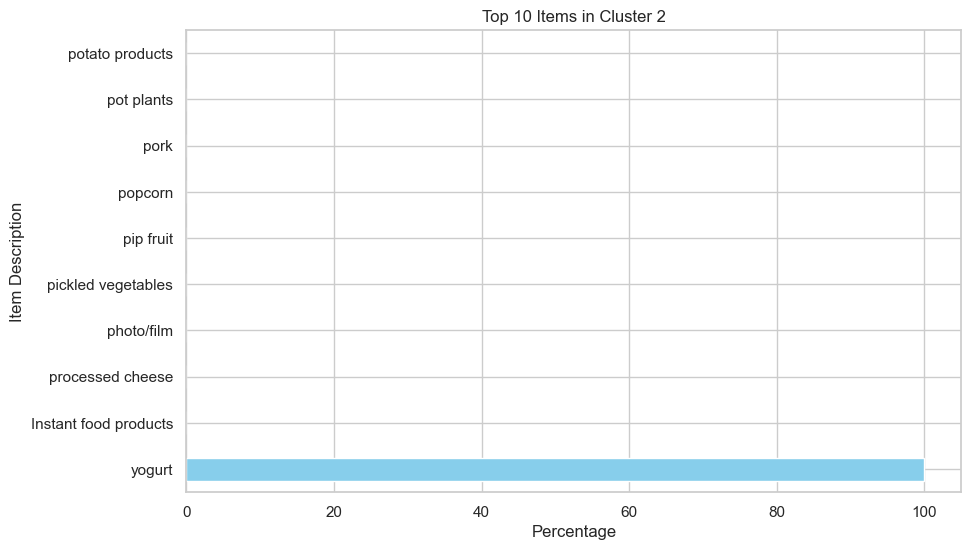

In [45]:
# Seaborn style
sns.set(style="whitegrid")

 # Calculating the total percentage of each item across all clusters
total_item_percentage = cluster_item_distribution_percentage.mean()

# The top items based on their overall percentage
plt.figure(figsize=(12, 6))
total_item_percentage.sort_values(ascending=False).head(15).plot(kind='bar', color='skyblue')
plt.title('Top 15 Items Across All Clusters')
plt.xlabel('Item Description')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()

# To visualize the top items for each cluster
for cluster in cluster_item_distribution_percentage.index:
    plt.figure(figsize=(10, 6))
    top_items = cluster_item_distribution_percentage.loc[cluster].sort_values(ascending=False).head(10)
    top_items.plot(kind='barh', color='skyblue')
    plt.title(f'Top 10 Items in Cluster {cluster}')
    plt.xlabel('Percentage')
    plt.ylabel('Item Description')
    plt.show()

# Recommendations

## Market Basket Analysis

### Association Rules and Network Graph

To better understand the relationships between items and provide recommendations for product placement or marketing strategies,I was able to perform Market Basket Analysis using the Apriori algorithm. The association rules generated from this analysis help identify items that are frequently purchased together.



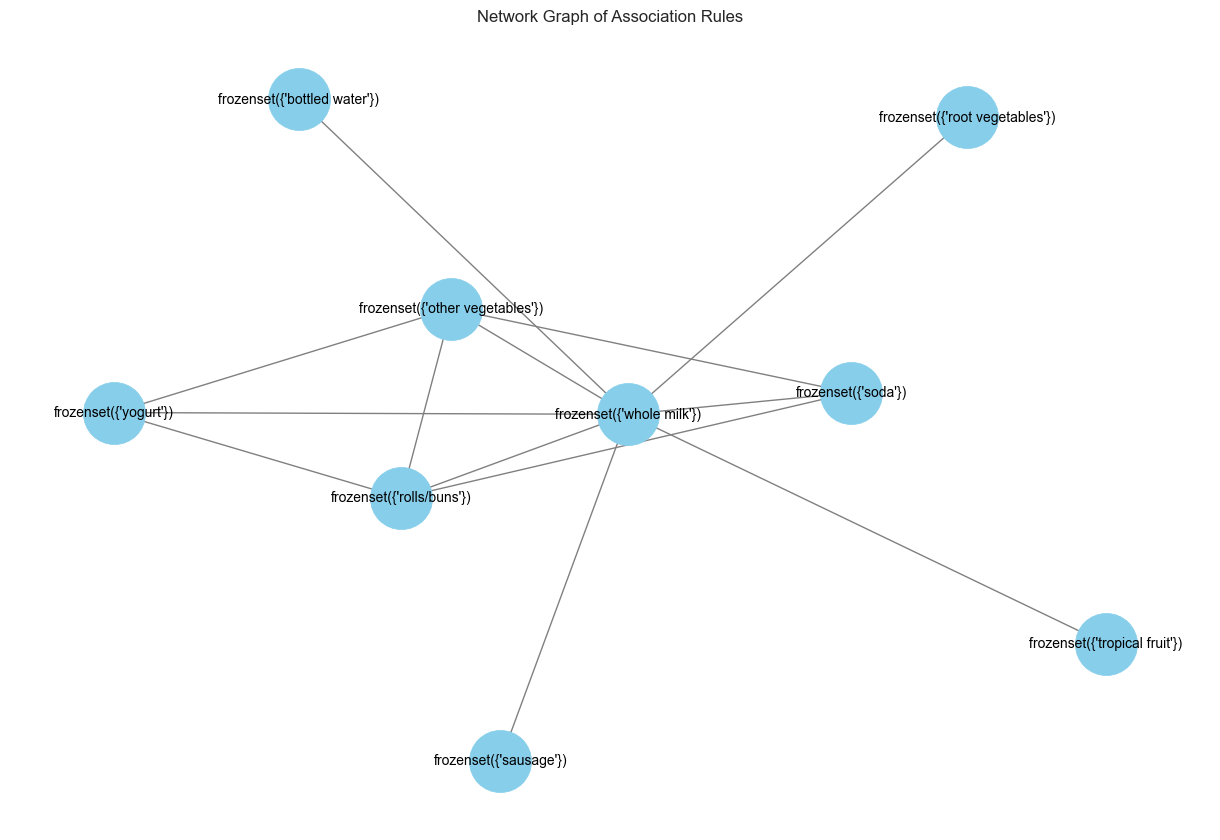

In [46]:

basket = pd.get_dummies(market_basket['itemDescription']).groupby(market_basket['Member_number']).max()

# Applying Apriori algorithm
frequent_itemsets = apriori(basket, min_support=0.1, use_colnames=True)

# Generating association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Network graph from association rules
G = nx.from_pandas_edgelist(rules, 'antecedents', 'consequents')

# Drawing the network graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=1)
nx.draw(G, pos, with_labels=True, font_size=10, node_size=2000, font_color='black', node_color='skyblue', edge_color='gray', linewidths=0.5)
plt.title('Network Graph of Association Rules')
plt.show()